In [112]:
import pandas as pd
from sklearn.preprocessing import Imputer
from easymoney.money import EasyPeasy
from time import time
import numpy as np
import math

In [110]:
# import the data set
movieDS = pd.read_csv('../Desktop/movie_metadata.csv')



In [111]:
# print out first few

movieDS.gross


0       760505847.0
1       309404152.0
2       200074175.0
3       448130642.0
4               NaN
5        73058679.0
6       336530303.0
7       200807262.0
8       458991599.0
9       301956980.0
10      330249062.0
11      200069408.0
12      168368427.0
13      423032628.0
14       89289910.0
15      291021565.0
16      141614023.0
17      623279547.0
18      241063875.0
19      179020854.0
20      255108370.0
21      262030663.0
22      105219735.0
23      258355354.0
24       70083519.0
25      218051260.0
26      658672302.0
27      407197282.0
28       65173160.0
29      652177271.0
           ...     
5013            NaN
5014            NaN
5015      1227508.0
5016            NaN
5017            NaN
5018            NaN
5019            NaN
5020            NaN
5021       192467.0
5022            NaN
5023        76382.0
5024            NaN
5025       180483.0
5026       136007.0
5027       673780.0
5028            NaN
5029        94596.0
5030            NaN
5031            NaN


In [79]:
# these are the features to be removed
# we chose these because we do not believe they are relevant enough to consider for prediction

featRemove = ['aspect_ratio', 'movie_imdb_link', 'facenumber_in_poster']

# remove all of the features we indicated above

movieDS = movieDS.drop(labels=featRemove, axis=1, inplace=False, errors='raise')

In [80]:
# we show that now we only have 25 features instead of 28
movieDS.shape

(5043, 25)

In [59]:
#  This is searching for all of the unique countries and how many times they appear
#  A list is being built to drop countries with only 1 film end result is 28

c_count = 1
country_count = {}
to_drop = []
for x in movieDS['country']:
    if x not in country_count:
        country_count[x] = c_count
    else:
        country_count[x] += 1
        
for x in country_count:
    if country_count[x] < 5:
        to_drop.append(x)
len(to_drop)

40

In [8]:
#  All of the countries and how many times they appear

c_count = 1
country_count = {}
for x in xWords['country']:
    if x not in country_count:
        country_count[x] = c_count
    else:
        country_count[x] += 1
        
country_count

NameError: name 'xWords' is not defined

In [44]:
# These are countries that appear with a different name in the easymoney library

prob_list = ['USA', 'UK', 'South Korea', 'Russia', 'West Germany', 'Taiwan', 'Iran', 'Argentina']
resolve_list = ['United States', 'United Kingdom', 'Korea, Republic of', 'Russian Federation', 'Germany', 'China', 'Turkey', 'Brazil']

prob_dict = {}

for x in range(len(prob_list)-1):
    prob_dict[prob_list[x]] = resolve_list[x]
    
prob_dict

{'Iran': 'Turkey',
 'Russia': 'Russian Federation',
 'South Korea': 'Korea, Republic of',
 'Taiwan': 'China',
 'UK': 'United Kingdom',
 'USA': 'United States',
 'West Germany': 'Germany'}

At this point, the DataFrame has 25 features, with samples that contain NaN

The threshold for the missing data value tolerance is going to be 4 missing values.

In [81]:
# here we are asserting that we will only accept samples that have 4 or less missing values
# this is to help make sure our samples aren't -too- incomplete

count = 0
rows = movieDS.shape[0]
for f in range(0, rows):
    
#         print('in here')
    # counts the number of null values for the row
    if(movieDS.ix[f].isnull().sum() >= 3):
        # if more than or equal to 4, remove them from the dataset
        movieDS = movieDS.drop(count)
    elif(np.isnan(movieDS.ix[f]['title_year'])):
        movieDS = movieDS.drop(count)
    elif(np.isnan(movieDS.ix[f]['budget'])):
        movieDS = movieDS.drop(count)
    elif(np.isnan(movieDS.ix[f]['gross'])):
        movieDS = movieDS.drop(count)
    elif movieDS.ix[f]['country'] in to_drop:
        movieDS = movieDS.drop(count)
    elif movieDS.ix[f]['country'] in prob_dict:
        movieDS.ix[f,'country'] = prob_dict[movieDS.ix[f]['country']]
    count += 1

In [82]:
# here we show the difference in the amount of samples after our sample check
# 5043 samples at the start
# 4888 samples after sample check
# 155 samples removed
# compare this to the ~1300 samples that contain at least 1 null feaature
# we salvage ~97% of samples using this method instead of only ~75%
# keep in mind, however, that we TRY to salvage the samples with this method
# this is not guaranteed to provide a 'better' model

print(rows)
rows = movieDS.shape[0]
movieDS.shape

5043


(3849, 25)

In [29]:
# get the feature column names
featureCols = []

for a in movieDS.columns:
    featureCols.append(a)

In [87]:
# categorical features
wordCols = ['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name', \
            'movie_title', 'actor_3_name', 'plot_keywords', 'language', 'country', 'content_rating']

# discrete features
numCols = ['num_critic_for_reviews', 'duration','director_facebook_likes', \
           'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', \
           'cast_total_facebook_likes', 'num_user_for_reviews', 'budget', \
           'title_year','actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes', 'gross']

In [88]:
# splitting the categorical features from the DataFrame
xWords = movieDS[wordCols]

# splitting the discrete features from the DataFrame
xNums = movieDS[numCols]

# splitting the desired label from the DataFrame
y = movieDS['gross']

# if we add the columns of each matrix/dataframe, we should end up with our original 25 columns/features
print(xWords.shape[1] + xNums.shape[1] + 1)

26


In [15]:

# create an instance of the class to update the latest information
ep = EasyPeasy()

In [83]:
movieDS = movieDS.reset_index()

In [55]:
movieDS[0:100]

,index,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,...,avatar|future|marine|native|paraplegic,3054.0,English,United States,PG-13,237000000.0,2009.0,936.0,7.9,33000
1,1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,...,goddess|marriage ceremony|marriage proposal|pi...,1238.0,English,United States,PG-13,300000000.0,2007.0,5000.0,7.1,0
2,2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,...,bomb|espionage|sequel|spy|terrorist,994.0,English,United Kingdom,PG-13,245000000.0,2015.0,393.0,6.8,85000
3,3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,...,deception|imprisonment|lawlessness|police offi...,2701.0,English,United States,PG-13,250000000.0,2012.0,23000.0,8.5,164000
4,5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,...,alien|american civil war|male nipple|mars|prin...,738.0,English,United States,PG-13,263700000.0,2012.0,632.0,6.6,24000
5,6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,...,sandman|spider man|symbiote|venom|villain,1902.0,English,United States,PG-13,258000000.0,2007.0,11000.0,6.2,0
6,7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,...,17th century|based on fairy tale|disney|flower...,387.0,English,United States,PG,260000000.0,2010.0,553.0,7.8,29000
7,8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,...,artificial intelligence|based on comic book|ca...,1117.0,English,United States,PG-13,250000000.0,2015.0,21000.0,7.5,118000
8,9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,...,blood|book|love|potion|professor,973.0,English,United Kingdom,PG,250000000.0,2009.0,11000.0,7.5,10000
9,10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,...,based on comic book|batman|sequel to a reboot|...,3018.0,English,United States,PG-13,250000000.0,2016.0,4000.0,6.9,197000


In [86]:

start = time()
no_work = []
for x in range(0,rows):
#     print(x)
#     print(count, ': ')
    try:
        mon_budget = ep.currency_converter(amount=int(movieDS.ix[x]['budget']), \
                                    from_currency=movieDS.ix[x]['country'], to_currency='USD')
        mon_gross = ep.currency_converter(amount=int(movieDS.ix[x]['gross']), \
                                    from_currency=movieDS.ix[x]['country'], to_currency='USD')
    except:
        no_work.append([movieDS.ix[x]['country'], int(movieDS.ix[x]['gross'])])
    try:
        movieDS.ix[f,'budget'] = ep.normalize(amount = mon_budget, region='USA', base_currency="USD", \
                                               from_year=movieDS.ix[x]['title_year'], to_year='latest')
        movieDS.ix[f,'gross'] = ep.normalize(amount = mon_gross, region='USA', base_currency="USD", \
                                               from_year=movieDS.ix[x]['title_year'], to_year='latest') 
    except:
        no_work.append([movieDS.ix[x]['country'], int(movieDS.ix[x]['budget'])])
        
print(no_work)
print(len(no_work))
print('time: %.2f' % (time()-start))

/Users/edgar/Software/Jupyter/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1940.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/edgar/Software/Jupyter/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1927.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/edgar/Software/Jupyter/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1946.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/edgar/Software/Jupyter/l

[]
0
time: 23.65


/Users/edgar/Software/Jupyter/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1920.0 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [89]:
# create the Imputer used for handling NaN values
# use the 'mean' strategy 
imr = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

# fit our numerical feature matrix into our Imputer
# (calculates the mean for each of the features)
imr = imr.fit(xNums)

# transform all the 'NaN' values into the 'mean' values that we calculated for that features
xNumsImputed = imr.transform(xNums.values)

# create a new DataFrame using the Inputed values
imputedDF = pd.DataFrame(data=xNumsImputed, columns=numCols)

In [90]:
# create a normalization function to range values from [-1,1]

def scaleData(num):
    maxNum = num.max()
    minNum = num.min()
    reList = []
    for n in num:
        reList.append((-1 + ((n - minNum)*(1 + 1)/(maxNum - minNum))))
    return reList

# apply our normalization function to the imputed values
imputedDF = imputedDF.apply(scaleData)

In [91]:
# check for null values in the numerical feature matrix
imputedDF.isnull().sum()

num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
num_voted_users              0
cast_total_facebook_likes    0
num_user_for_reviews         0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
gross                        0
dtype: int64

In [92]:
# check for null values in the categorical feature matrix
xWords.isnull().sum()

color              3
director_name      1
actor_2_name       1
genres             1
actor_1_name       1
movie_title        1
actor_3_name       5
plot_keywords     29
language           4
country            1
content_rating    45
dtype: int64

In [93]:
# reset the index so the dataframes have something to join on
# since xWords derives from the dataframe with the dropped rows, the indices need to be reset to account for the dropped rows

xWords = xWords.reset_index()


In [94]:
# now we can merge the numerical imputed values with our categorical values based on their corresponding indices
x = pd.merge(left=imputedDF, right=xWords,left_index = True, right_index = True)

imputedDF[::1000]


,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,gross
0,0.778325,-0.027027,-1.000000,-0.925652,-0.996875,0.048906,-0.985279,0.206958,-0.961197,0.854167,-0.986336,0.636364,-0.810888,1.000000
1000,-0.628079,-0.466216,-0.971913,-0.927391,-0.996875,-0.913523,-0.985808,-0.834750,-0.992141,0.645833,-0.985737,0.350649,-1.000000,-0.817742
2000,-0.637931,-0.554054,-0.976957,-0.976957,-0.996909,-0.957438,-0.991918,-0.943467,-0.996726,0.958333,-0.987883,-0.142857,-0.936963,-0.777732
3000,-0.413793,-0.608108,-0.943043,-0.992348,-0.925000,-0.772757,-0.923585,-0.872702,-0.998936,0.770833,-0.987898,0.558442,-1.000000,-0.934802


In [95]:
print(x.shape)
x[::1000]

(3850, 26)


,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,budget,title_year,...,director_name,actor_2_name,genres,actor_1_name,movie_title,actor_3_name,plot_keywords,language,country,content_rating
0,0.778325,-0.027027,-1.000000,-0.925652,-0.996875,0.048906,-0.985279,0.206958,-0.961197,0.854167,...,James Cameron,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,Wes Studi,avatar|future|marine|native|paraplegic,English,United States,PG-13
1000,-0.628079,-0.466216,-0.971913,-0.927391,-0.996875,-0.913523,-0.985808,-0.834750,-0.992141,0.645833,...,John McTiernan,Faye Dunaway,Crime|Romance|Thriller,Mark Margolis,The Thomas Crown Affair,Denis Leary,art|insurance investigator|martinique|painting...,English,United States,R
2000,-0.637931,-0.554054,-0.976957,-0.976957,-0.996909,-0.957438,-0.991918,-0.943467,-0.996726,0.958333,...,Ben Falcone,Mark Duplass,Comedy,Gary Cole,Tammy,Ben Falcone,alcoholic|grandmother|highway travel|niagara f...,English,United States,R
3000,-0.413793,-0.608108,-0.943043,-0.992348,-0.925000,-0.772757,-0.923585,-0.872702,-0.998936,0.770833,...,Jason Reitman,Cameron Bright,Comedy|Drama,J.K. Simmons,Thank You for Smoking,Todd Louiso,cigarette smoking|lobbyist|political satire|re...,English,United States,R


In [96]:
# Using Homework 4's algorithm on Numerical Feature Matrix

# import all necessary libraries
# standard impotr of pandas and numpy
import pandas as pd
import numpy as np

# used for plotting
import matplotlib.pyplot as plt

# used for normalization
from sklearn.preprocessing import MinMaxScaler

# used for calculating distances
from numpy.linalg import norm

# used for making deepcopies of lists
from copy import deepcopy

# used for generating random values for initial points
import random as rd

# used for using scikit Kmeans algorithm
from sklearn.cluster import KMeans

In [97]:
# ---------------------- CREATING OUR OWN K MEANS CLASSIFIER (CLASS OBJECT) --------------------------
class MyKC():
        
    # ---------- Initialize the lists, k's, and other attributes for the classifier ----------
    def __init__(self, number_k=2):
        self.k = number_k
        self.init_p = []
        self.clusters = []


    # ------------------- USED FOR TESTING PURPOSES --------------------
    # ------------- PRINTS CENTROID POINTS, CLUSTERS, AND NUMBER OF ITEMS IN EACH CLUSTER -------------------
    def printall(self):
        print("\n----------------------------------------BEGIN PRINT ALL----------------------------------------\n")
        print("\n\t\t\tInitial Points:\n\t", self.init_p)
        print("\n\t\t\tClusters:\n\t", self.clusters)
        lst = []
        count = 0;
        for i in self.clusters:
            lst.append(len(i))
        print("\n\t\t\tNumber of items in each cluster: (",lst,")")
        print("\n---------------------------------------END PRINT ALL-------------------------------------------\n")
        
    # ~~~~~~~~~~~~~ STEP 0 ~~~~~~~~~~~~~~~~
    # ~~~~~~~~~~~~~ INITIALIZE K RANDOM POINTS AS THE INITIAL CENTROIDS ~~~~~~~~~~~~~
    def randomizer(self, D):
        # create a list of random points
        for i in range(self.k):
            self.init_p.append([])
            for j in range(self.D):
                self.init_p[i].append(rd.random())
        self.cluster_assignment()

        
    # ~~~~~~~~~~~~ STEP 1 ~~~~~~~~~~~~~
    # ~~~~~~~~~~~~ ASSIGN EACH DATA SAMPLE TO THE NEAREST CENTROID POINT ~~~~~~~~~~~~~~~~
    def cluster_assignment(self, abcdef = 0):
        self.clusters = []
        for k in range(self.k):
            self.clusters.append([])

        for i in self.data:
            distances = list()
            for j in self.init_p:
                d1 = norm(i)
                d2 = norm(j)
                d = abs(d1 - d2)
                distances.append(d)
            smallest_d = min(distances)
            index = distances.index(smallest_d)
            self.clusters[index].append(i)
        self.tries += 1
        self.centroid_move()

        
#    ~~~~~~~~~~~~~ STEP 2 ~~~~~~~~~~~~~~~
#    ~~~~~~~~~~~~~ FIND THE NEW CENTROIDS BY CALCULATING THE MEAN OF THE CURRENT CLUSTER ~~~~~~~~~~~
    def centroid_move(self):
        newlst = []
        for q in self.clusters:
            q = np.array(q)
            
            if (len(q) != 0):
                avg = sum(q)/(len(q))
            else:
                avg = np.zeros((self.D, ))
            avg = avg.tolist()
            newlst.append(avg)
        
        if (self.init_p == newlst):
            print("Trained!")
        elif (self.init_p != newlst and self.tries < 50):
            self.init_p = deepcopy(newlst)
            self.cluster_assignment()
        else:
            print("Took more than 50 loops to train!")

    # normalize our data 
    def makenormal(self, f_train):
        A = f_train
        mms = MinMaxScaler()
        self.data = mms.fit_transform(A)
        self.data = pd.DataFrame(self.data)
        self.data = self.data.get_values()
        self.data = self.data.tolist()
        self.D = len(list(A.columns.values))
    
    def fit(self, f_train):
        self.makenormal(f_train)
        self.tries = 0
        self.randomizer(self.D)
        
    # not implemented because we aren't predicting
    def predict(self, f_test):
        pass
    



Trained!


<function matplotlib.pyplot.show>

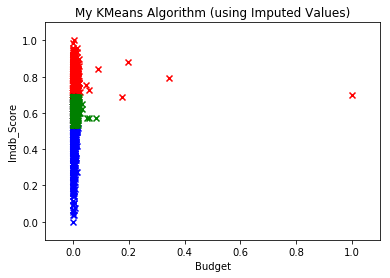

In [98]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['budget', 'imdb_score']]

mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Budget')
plt.ylabel('Imdb_Score')

plt.show



In [ ]:
# We can see that typically Budget does not affect IMDB_Score as much as we would probably assume 


Trained!


<function matplotlib.pyplot.show>

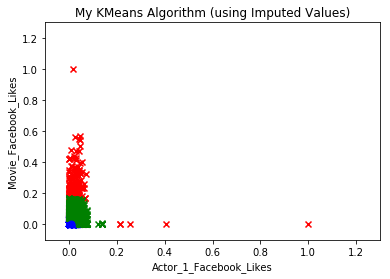

In [99]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['actor_1_facebook_likes', 'movie_facebook_likes']]

mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-0.1,1.3])
plt.ylim([-0.1,1.3])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Actor_1_Facebook_Likes')
plt.ylabel('Movie_Facebook_Likes')

plt.show



In [ ]:
# Here we see that Actor Facebook likes affect Movie Facebook Likes more than Budget Affects IMDB_Score

Trained!


<function matplotlib.pyplot.show>

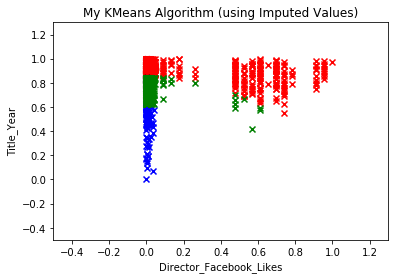

In [100]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['director_facebook_likes', 'title_year']]
mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-0.5,1.3])
plt.ylim([-0.5,1.3])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Director_Facebook_Likes')
plt.ylabel('Title_Year')

plt.show


In [ ]:
# Here we see that Directors of more recent movies have more Facebook Likes
# We can attribute that to the recent development of Facebook and Social Media

Trained!


<function matplotlib.pyplot.show>

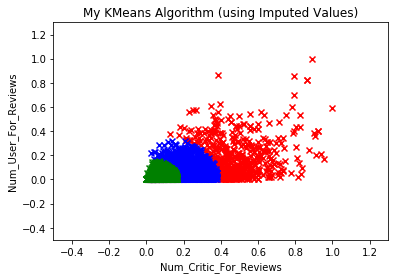

In [109]:
# Create our classifier
mc = MyKC(number_k=3)

# Train our classifier using the 'fit' method we defined above
imputedDFKMeans = imputedDF[['num_critic_for_reviews', 'gross']]
mc.fit(imputedDFKMeans)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ MY K MEANS ALGORITHM ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
%matplotlib inline

plt.figure
count = 0
for i, c in zip(mc.clusters, ['red','blue', 'green']):
    # each 'i' is a cluster
    plt.plot(mc.init_p[count][0], mc.init_p[count][1], color=c,marker='o', markersize='7')
    for j in i:
        # each 'j' is a point in cluster 'i'
        plt.scatter(j[0],j[1], color=c, marker='x')
    count += 1
    
plt.xlim([-0.5,1.3])
plt.ylim([-0.5,1.3])
plt.title('My KMeans Algorithm (using Imputed Values)')
plt.xlabel('Num_Critic_For_Reviews')
plt.ylabel('Gross')

plt.show


In [ ]:
# Here we see that there is a correlation between the number of reviews by critics and the number of reviews by Users
# A higher amount of critic reviews means there is probably a higher amount of User Reviews

In [ ]:
# We can create multiple combinations of these graphs and see if there is a correlation between features

In [ ]:
# We impute the label so that our KNN model can work with the values in the 'gross' label
# we can use the same imputer from above


In [103]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [105]:
xC = imputedDF[:]
# yC = yImputed[:]
yC = y[:]

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

 
#split the data in to training and testing with a random state of 2.

xcTrain, xcTest, ycTrain, ycTest = train_test_split(xC, yC, test_size=0.4, random_state=2)


#Linear Regression object

myLinReg = LinearRegression()

myLinReg.fit(xcTrain, ycTrain)

# printing Theta0 using attribute "intercept_":
print(myLinReg.intercept_)

# printing [Theta1, Theta2, Theta3] using attribute "coef_":
print(myLinReg.coef_)
print(xC.columns)


# We see from the data that the highest absolute values for theta correspond to
# the 'actor_1_facebook_likes,' followed by 'cast_total_facebook_likes'

# And the worst is 'duration'


yPrediction = myLinReg.predict(xcTest)

# using rmse

# calculate the mean square error
mse = metrics.mean_squared_error(ycTest, yPrediction)

# using numpy to get the square root of the mse
rmse = np.sqrt(mse)

# print the rmse
print('RMSE:', rmse)

380253004.5
[  9.68575478e-08  -1.49011612e-08  -2.01165676e-07   3.30619514e-08
  -1.25356019e-06   2.91503966e-07   6.81728125e-07  -2.23517418e-08
  -2.77068466e-07  -1.26659870e-07   4.09781933e-08   1.11758709e-07
   1.53202564e-07   3.80252842e+08]
Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'cast_total_facebook_likes', 'num_user_for_reviews', 'budget',
       'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes', 'gross'],
      dtype='object')
RMSE: 1.08917437945e-07


/Users/edgar/Software/Jupyter/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [108]:
#using 10 fold fold validation

#instantiate the linear regression object and apply 10 fold cross validation to get the mean score error
myLinRegCV = LinearRegression()

mseScores = cross_val_score(myLinRegCV, xC, yC, scoring='neg_mean_squared_error', cv=10)


mseScores = -accuracyLinRegCV
print(mseScores)

rmseCV = np.sqrt(mseScores)
print(rmseCV)
print('Mean RMSE scores: ', rmseCV.mean())

[  2.10694377e-14   1.57611298e-14   1.68154091e-14   1.01367688e-14
   1.37102451e-14   1.45522843e-14   4.78624355e-14   2.99350732e-14
   4.29947564e-14   5.50758650e-15]
[  1.45153153e-07   1.25543338e-07   1.29674242e-07   1.00681521e-07
   1.17090756e-07   1.20632849e-07   2.18774851e-07   1.73017552e-07
   2.07351770e-07   7.42131154e-08]
Mean RMSE scores:  1.41213314738e-07
